In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as un
from astropy.visualization import quantity_support
import scipy as sp
from scipy.special import kv
from scipy.integrate import odeint

In [2]:
# %matplotlib notebook

In [3]:
#creating the grid x = r/r_lc

N_position = 100
x1 = 1.01
x2 = 2.

X = np.linspace(x1, x2, N_position)*un.dimensionless_unscaled     #Space of dimensionless radial positions

X_reversed = X[::-1]                                              #reversed matrix for the electron integration

In [4]:
# Values and units of physical constants and other quantities and parameters that are used through the code

e = const.e.esu       #Electron charge
m_e = const.m_e.cgs   #Electron mass
c = const.c.cgs       #Speed of light
h = const.h.cgs       #Planck's constant

G_cgs = un.cm**(-1/2)*un.g**(1/2)*un.s**(-1)   # define the G unit in cgs (esu) because astropy does not deal with it properly

r_surface = 10**6 * un.cm  #Surface of the NS
B_surface = 10**13 * G_cgs  #Magnetic field at the surface of the NS
Period = 0.033 * un.s      #Period of rotation

r_lc = c*Period/(2*np.pi)  #Light cylinder radius
B_lc = B_surface*r_surface**3/(2*r_lc**3)   #Magnetic field at the light cylinder

k = 2.   #Pair multiplicity

#Analytical expressions of fields and velocities as a function of the radial distance x

In [5]:
#radial speed 
def v_r(X):
    
    """
    input: X (radial distance)
    output: v_r (radial speed)
    
    description: The radial speed in cgs units, as a function of the dimensionless radial distance X, 
                 as given in Contopoulos, Petri, Stefanou 2019
    """
    
    v_r = c*np.sqrt(X**2 - 1)/X    
    
    return v_r 

In [6]:
#azimuthial speed 
def v_phi(X):
    
    """
    input: X (radial distance)
    output: v_phi (azimuthial speed)
    
    description: The azimuthial speed in cgs units, as a function of the dimensionless radial distance X, 
                 as given in Contopoulos, Petri, Stefanou 2019
    """
    
    v_phi = c/X
    
    return v_phi

In [7]:
#radial magnetic field
def B_r(X, k = k, B_lc = B_lc):
     
    """
    input: X (radial distance), k (multiplicity)
    output: B_r (radial magnetic field)
    
    description: The r component of the magnetic field in cgs units, as a function of the dimensionless radial distance X, 
                 as given in Contopoulos, Petri, Stefanou 2019
    """
    
    B_r = B_lc*(1/X**2)*(1-1/X**2)**0.7        
    
    return B_r

In [8]:
#vertical magnetic field
def B_z(X, k = k, B_lc = B_lc):
    
    """
    input: X (radial distance), k (multiplicity)
    output: B_z (z magnetic field)
    
    description: The z component of the magnetic field in cgs units, as a function of the dimensionless radial distance X, 
                 as given in Contopoulos, Petri, Stefanou 2019
    """
    
#     B_z = -1/(4*k*X)*np.gradient(X*np.sqrt(X**2-1)*B_r(X), X)            #using the gradient method of numpy
    
    B_z = B_lc*(-3)/(5*k*X**4)*(1-1/X**2)**0.2                             #explicit, already calculated the gradient
    
    return B_z 

In [ ]:
#Azimuthial magnetic field
def B_phi(X, k = k, B_lc = B_lc):

    Bphi = -B_lc/X

In [9]:
#radial electric field    
def E_r(X, k = k, B_lc = B_lc):
    
    """
    input: X (radial distance), k (multiplicity)
    output: E_r (radial magnetic field)
   
    description: The r component of the electric field in cgs units as, a function of the dimensionless radial distance X, 
                 as given in Contopoulos, Petri, Stefanou 2019
    """
    
    E_r = -X*B_z(X)   
    
    return E_r

#Definitions of various functions used through the code

In [10]:
#Radius of curvature
def R_curv(X, r_lc = r_lc):
    """
    input: X (radial distance), r_lc (light cylinder radius)
    output: R_curv (radius of curvature)
    
    description: Calculates the instantaneous radius of curvature of the orbit as a function of the 
    dimensionless radial distance. 
    """
    R_curv = X**2*r_lc
    
    return R_curv

In [33]:
#Larmor gyroradius
def r_g(X, gamma, k = k, B_lc = B_lc):

    '''
    input: X (radial distance), k (multiplicity), B_lc (magnetic field at the LC)
    output: rg (larmor ladius)

    description: Calculates the larmor radius of the synchrotron motion around B_phi as a function of the dimensionless radial                         distance X.
    '''

    rg = (m_e/e)*gamma*v_r(X)/B_phi(X)

    return rg

In [11]:
#The sin of the angle between the particle motion and the phi-direction
def sina(X):
    
    """
    input: X (radial distance)
    output: sina (sin of angle a)
    
    description: Calculates the sinus of the angle between the instantaneous direction of the particle and the 
                 cylindrical phi-direction as a function of the dimensionless radial distance. 
    """
    
    sina = np.sqrt(X**2 - 1)/X
    
    return sina

In [12]:
#The equation that gives the evolution of the Lorentz factor Γ
def evolution_of_gamma(gamma, X, k, charge_sign):
    
    '''
    input: gamma (lorentz factor), X (radial distance), k (multiplicity), charge_sign 
    output: dgdx (derivative of gamma over X)
    
    description: The derivative of the lorentz factor over the dimensionless radial distance, 
                 as given in Contopoulos, Petri, Stefanou 2019
    '''
    
    
    
    dgdx = charge_sign*e*r_lc/(m_e*c**2*sina(X))*(E_r(X)*sina(X) - (2*e*gamma**4)/(3*R_curv(X)**2))
    
#     if E_r(X)*sina - (2*e*gamma**4)/(3*R_curv(X)**2) > 0:
#         print(E_r(X)*sina(X) - (2*e*gamma**4)/(3*R_curv(X)**2), 'acc')
#     else:
#         print(E_r(X)*sina(X) - (2*e*gamma**4)/(3*R_curv(X)**2), 'rad')
        
    
    return dgdx

In [13]:
#Alternative form for the derivative of gamma, after some algebra has been done
def evolution_of_gamma_2(gamma, X, k, charge_sign):
    
    '''
    input: gamma (lorentz factor), X (radial distance), k (multiplicity), charge_sign 
    output: dgdx (derivative of gamma over X)
    
    description: The derivative of the lorentz factor over the dimensionless radial distance, 
                 as given in Contopoulos, Petri, Stefanou 2019
    '''

    #   Term of numerical constants
    num_term = r_lc*e*B_lc/(m_e*c**2)


    #   Lorentz factor at the radiation reaction limit
    gamma_rrl = (3*r_lc**2*B_lc/(2*e))**(1/4) #/ (r_lc.unit**2*B_lc.unit/e.unit)**(1/4)  
    
    
    dgdx = charge_sign*num_term*(3/(5*k*X**3)*(1-1/X**2)**0.2 - 
                                 (gamma/gamma_rrl)**4*(r_lc/R_curv(X))**2*(1-1/X**2)**(-0.5))
    
    return dgdx


In [14]:
#The critical frequency of curvature radiation
def nu_crit(X, gamma):
    
    '''
    input: X (radial position), gamma (lorentz factor)
    output: nu_crit (critical frequency):
    
    description: Takes the dimensionless radial position and the respective lorentz factor and returns the instantaneous 
                 critical frequency of curvature radiation.
    '''
    
    n_c = 3*c/2*gamma**3/R_curv(X)
    
    return n_c

In [15]:
#Define the curvature radiation spectrum of one particle with given R_c and Γ
def curvature_spectrum(X, nu, gamma):
     
    '''
    input : nu (frequency), nu_crit (critical frequency), R_curv (radius of curvature), gamma (lorentz factor)
    output : power(nu) (spectrum)
    
    description: The spectrum of curvature radiation from a particle moving with lorentz factor gamma 
                 in a curved trajectory of radius R_curv.
    '''
    
    integral = sp.integrate.quad(lambda z: kv(5./3., z), nu/nu_crit(X, gamma), +np.inf)[0]*un.dimensionless_unscaled
    
    power = np.sqrt(3)*e**2/(2*np.pi)*gamma/R_curv(X)*nu/nu_crit(X, gamma)*integral
    
    return power


#Begin the calculations and plot the results

In [16]:
#Integrate the equation

gamma_0 = 10.   #initial value of Γ

#-------------------------------------------------------------

#positrons
gamma_positron = odeint(evolution_of_gamma, gamma_0, X, args = (k, +1))         #for positrons
gamma_positron = gamma_positron.reshape(N_position,)*un.dimensionless_unscaled  #reshape to a convenient form

#-------------------------------------------------------------

#electrons
gamma_electron = odeint(evolution_of_gamma, gamma_0, X_reversed, args = (k, -1))  #for electrons
gamma_electron = gamma_electron.reshape(N_position,)*un.dimensionless_unscaled    #reshape to a convenient form

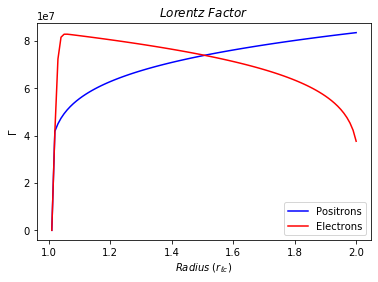

In [32]:
#Plot the evolution of Γ


# quantity_support()
fig, ax = plt.subplots()

ax.plot(X, gamma_positron, label = 'Positrons', c = 'b')
ax.plot(X, gamma_electron, label = 'Electrons', c = 'r')

# gamma_rrl = (3*r_lc**2*B_lc/(2*e))**(1/4)
# gamma_max_positron = (3/(5*k*X**3)*(R_curv(X)/r_lc)**2*gamma_rrl**4*(1-1/X**2)**0.7)**(1/4)

# ax.plot(X, gamma_max_positron)
#Format options for the plot
ax.set_xlabel('$Radius \ (r_{\ell c})$')
ax.set_ylabel('$\Gamma$')
ax.set_title('$Lorentz \ Factor$')
ax.legend()

#ax.savefig('ECS_gamma_k2_test.png')

In [18]:
# Define the surface charge density of the particles in the ECS.

def sigma_electron(X, k = k, P = Period):
     
    """
    input : X (radial distance), k (multiplicity), P (rotational period of the pulsar)
    output : sigma_electron (charge/area)
    
    description: Calculates the surface charge density of the electrons in the ECS as a function of the X,
                 as given in CPS19
                 
    """
    
    s_elec = -2*k*r_lc/(X*v_r(X)*P) * sp.integrate.quad(lambda Y: Y*np.abs(B_z(Y).value), X, +np.inf)[0]*B_z(X).unit
    
    return s_elec

def sigma_positron(X, k = k, P = Period):
    
    """
    input : X (radial distance), k (multiplicity), P (rotational period of the pulsar)
    output : sigma_positron (charge/area)

    description: Calculates the surface charge density of the positrons that enter the ECS through open field lines as a function of                   X, as given in CPS19
                    
    """

    s_pos = 2*k*r_lc/(X*v_r(X)*P) * sp.integrate.quad(lambda Y: Y*np.abs(B_z(Y).value), 1, X)[0]*B_z(X).unit

    return s_pos

def sigma_separatrix(X, k = k, P = Period):
    
    """
    input : X (radial distance), k (multiplicity), P (rotational period of the pulsar)
    output : sigma_separatrix (charge/area)

    description: Calculates the surface charge density of the positrons that originate from the separatrix and are needed for the                      total sigma to approach zero at the Y-point as a function of X, as given in CPS19.
                    
    """

    s_sep = 2*k*r_lc/(X*v_r(X)*P) * sp.integrate.quad(lambda Y: Y*np.abs(B_z(Y).value), 1, +np.inf)[0]*B_z(X).unit

    return s_sep


In [19]:
#Integrate the surface charge density in order to calculate the accumulated absolute number of the particles.

def accumulated_number_electron(X, k = k, P = Period):
    """
    input : X (radial distance), k (multiplicity), P (rotational period of the pulsar)
    output : N_e(X) (number of electrons)
    
    description: Calculates the total number of electrons at some distance X from their surface charge density.
    """
    
    acc_N_e = 2*np.pi*r_lc**2/(-e)*sp.integrate.quad(lambda Y: Y*sigma_electron(Y).value, X, +np.inf)[0]*sigma_electron(X).unit
    
    return acc_N_e

def accumulated_number_positron(X, k = k, P = Period):
    """
    input : X (radial distance), k (multiplicity), P (rotational period of the pulsar)
    output : N_p(X) (number of positrons)
    
    description: Calculates the total number of positrons at some distance X from their surface charge density.
    """
    
    acc_N_p = (2*np.pi*r_lc**2/e*sp.integrate.quad(lambda Y: Y*sigma_positron(Y).value, 1, X)[0]*sigma_positron(X).unit + 
           2*np.pi*r_lc**2/e*sp.integrate.quad(lambda Y: Y*sigma_separatrix(Y).value, 1, X)[0]*sigma_separatrix(X).unit)
    
    return acc_N_p

In [20]:
#Define the absolute number of particles inside the interval x+dx

def absolute_number_positron(X, k = k, P = Period, B = B_lc):

    dx = 1/N_position

    N_p = 2*np.pi*r_lc**2/e*(sigma_positron(X) + sigma_separatrix(X))*X*dx

    return N_p

def absolute_number_electron(X, k = k, P = Period, B = B_lc):

    dx = 1/N_position

    N_e = 2*np.pi*r_lc**2/(-e)*sigma_electron(X)*X*dx

    return N_e

In [21]:
positron_number = np.ones(N_position)*un.dimensionless_unscaled
electron_number = np.ones(N_position)*un.dimensionless_unscaled

for i in range(N_position):
    electron_number[i] = absolute_number_electron(X[i]).decompose()
    positron_number[i] = absolute_number_positron(X[i]).decompose()
    print(i)
    # print(electron_number)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


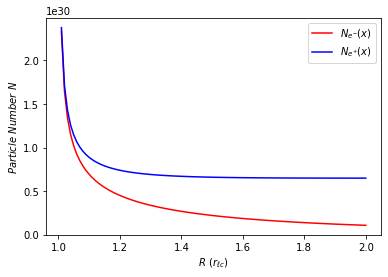

In [31]:
fig, ax = plt.subplots()

ax.plot(X, electron_number, label = "$N_{e^{-}}(x)$", c = 'r')
ax.plot(X, positron_number, label = "$N_{e^{+}}(x)$", c = 'b')

ax.set_xlabel('$R \ (r_{\ell c})$')
ax.set_ylabel('$Particle \ Number \ N$')
ax.legend()

In [23]:
#Calculate the spectrum of the particles

#Frequency grid
N_frequency = 100        #Number of frequencies in which the spectrum is calculated
f1 = 20                  #Minimum 
f2 = 30                  #Maximum 
frequency = np.logspace(f1, f2, N_frequency)*un.Hz       #Frequencies distributed evenly in a logarithmic space
photon_energy = (frequency*h).to(un.eV)                  #Corresponding energies in eV



#Initializing the matrix of the instantaneous power per frequency
instant_ppf_positron = np.zeros((N_frequency, N_position))*(e.unit**2/r_lc.unit)     #units correspond to power per
instant_ppf_electron = np.zeros((N_frequency, N_position))*(e.unit**2/r_lc.unit)     #frequency: (erg/s)/Hz = erg

#Initializing the matrix of the power per frequency of the trajectory
traj_ppf_positron = np.zeros((N_frequency))*instant_ppf_positron.unit
traj_ppf_electron = np.zeros((N_frequency))*instant_ppf_electron.unit

#Initializing the matrix of the total power per frequency (entire trajectory + population of particles)
total_ppf_positron = np.zeros((N_frequency))*instant_ppf_positron.unit
total_ppf_electron = np.zeros((N_frequency))*instant_ppf_electron.unit

#----------------------------------------------------------------------------------------------

#Spectrum calculation
for nu in range(N_frequency-1):
    print(nu)
    for i in range(N_position-1):
        
        #Positrons
        
        #the instantaneous power per frequency emitted by a positron in position X
        instant_ppf_positron[nu][i] = curvature_spectrum(X[i], frequency[nu], gamma_positron[i])
        
        #the power per frequency emitted along the whole trajectory
        traj_ppf_positron[nu] += instant_ppf_positron[nu][i]
        
        #the total power per frequency emitted by all the positrons
        total_ppf_positron[nu] += positron_number[i]*instant_ppf_positron[nu][i]
        
    # ---------------------------------------------------------------------------------------------
        
        #Electrons
        
        #the instantaneous power per frequency emitted by a positron in position X
        instant_ppf_electron[nu][i] = curvature_spectrum(X[i], frequency[nu], gamma_electron[i])
        
        #the total power per frequency emitted along the whole trajectory
        traj_ppf_electron[nu] += instant_ppf_electron[nu][i]
        
        #the total power per frequency emitted by all the electrons
        total_ppf_electron[nu] += electron_number[i]*instant_ppf_electron[nu][i]

0
/home/petros/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  if sys.path[0] == '':
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


In [24]:
# The luminocity by the positrons
power_positron = frequency*total_ppf_positron

#-------------------------------------

# The luminocity by the electrons
power_electron = frequency*total_ppf_electron

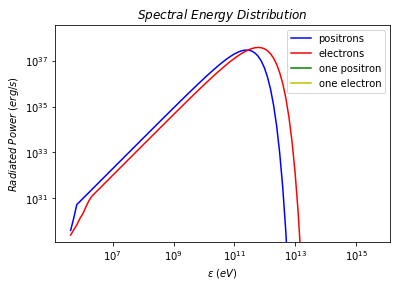

In [30]:
# Spectrum plots

# %matplotlib notebook

fig, ax = plt.subplots()

ax.plot(photon_energy, power_positron, label = 'positrons', c = 'b')
ax.plot(photon_energy, power_electron, label = 'electrons', c = 'r')

ax.plot(photon_energy, frequency*traj_ppf_positron, label = 'one positron', c = 'g')
ax.plot(photon_energy, frequency*traj_ppf_electron, label = 'one electron', c = 'y')


# ax.plot(photon_energy, frequency*traj_ppf_positron, label = 'trajectory', c = 'b')
# for i in range(N_position):
#     ax.plot(photon_energy, frequency*instant_ppf_positron[:,i], c = 'r')

ax.set_xscale('log')
ax.set_yscale('log')

#adjust limits depending on the data values
ax.set_ylim(bottom = 0.5*min(power_positron[0].value, power_electron[0].value), 
            top = 10*max(max(power_positron.value), max(power_electron.value)))

#set axis labels and title
ax.set_xlabel('$\epsilon \ (eV)$')
ax.set_ylabel('$Radiated \ Power \ (erg/s)$')
ax.set_title('$Spectral \ Energy \ Distribution$')

#set legend
ax.legend()

# plt.savefig('images/Spectrum.png')

In [26]:
acc_power_positron = e*r_lc/(m_e*c**2*sina(X))*(E_r(X)*sina(X) - (2*e*gamma_positron**4)/(3*R_curv(X)**2))
acc_power_electron = e*r_lc/(m_e*c**2*sina(X))*(E_r(X)*sina(X) - (2*e*gamma_electron**4)/(3*R_curv(X)**2))



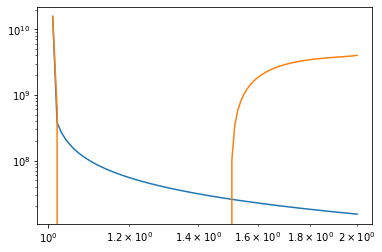

In [27]:

fig, ax = plt.subplots()

ax.plot(X, acc_power_positron)
ax.plot(X, acc_power_electron)
ax.set_xscale('log')
ax.set_yscale('log')

In [28]:
dx = (X[30]-X[28])/2
dx

<Quantity 0.01>

In [29]:
print(sigma_positron(X[50]))

45063.183754977195 g(1/2) / (cm(1/2) s)
